In [1]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCHarmonic"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCHarmonic.dat"),'w')

In [2]:
# VMC for the one-dimensional harmonic oscillator
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from decimal import *
# Trial wave function for the Harmonic oscillator in one dimension
def WaveFunction(r,alpha):
    return exp(-0.5*alpha*alpha*r*r)

# Local energy  for the Harmonic oscillator in one dimension
def LocalEnergy(r,alpha):
    return 0.5*r*r*(1-alpha**4) + 0.5*alpha*alpha

In [19]:
a2 = 0.51

print((2 * a2)**0.5)

1.0099504938362078


In [3]:
# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
@jit
def MonteCarloSampling():

    NumberMCcycles= 100000
    StepSize = 1.0
    # positions
    PositionOld = 0.0
    PositionNew = 0.0

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.4
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0
        #Initial position
        PositionOld = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position 
            PositionNew = PositionOld + StepSize*(random() - .5)
            wfnew = WaveFunction(PositionNew,alpha)
            #Metropolis test to see whether we accept the move
            if random() <= wfnew**2 / wfold**2:
                PositionOld = PositionNew
                wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        #We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy    
        Variances[ia] = variance    
        outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))
    return Energies, AlphaValues, Variances

<ipython-input-3-1cb459bc8a5d>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MonteCarloSampling" failed type inference due to: Untyped global name 'WaveFunction': cannot determine Numba type of <class 'function'>

File "<ipython-input-3-1cb459bc8a5d>", line 23:
def MonteCarloSampling():
    <source elided>
        PositionOld = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        ^

  @jit
<ipython-input-3-1cb459bc8a5d>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "MonteCarloSampling" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-3-1cb459bc8a5d>", line 17:
def MonteCarloSampling():
    <source elided>
    alpha = 0.4
    for ia in range(MaxVariations):
    ^

  @jit
C:\Users\KarlH\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:178: NumbaWarning: F

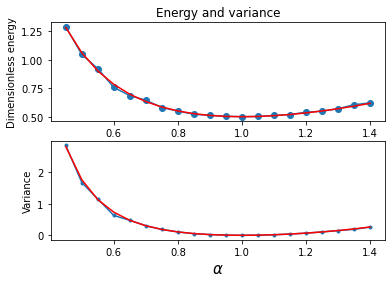

    Alpha    Energy  Exact Energy  Variance  Exact Variance
0    0.45  1.290137      1.285193  2.840500        2.803442
1    0.50  1.047439      1.062500  1.668106        1.757812
2    0.55  0.922154      0.902071  1.146099        1.127465
3    0.60  0.756961      0.784444  0.626393        0.730706
4    0.65  0.685189      0.697341  0.473361        0.472569
5    0.70  0.644835      0.632704  0.303868        0.300629
6    0.75  0.580576      0.585069  0.185531        0.184613
7    0.80  0.549694      0.550625  0.106882        0.106376
8    0.85  0.521459      0.526646  0.050482        0.054712
9    0.90  0.512073      0.511142  0.023631        0.022532
10   0.95  0.503848      0.502633  0.005557        0.005280
11   1.00  0.500000      0.500000  0.000000        0.000000
12   1.05  0.502019      0.502382  0.004780        0.004776
13   1.10  0.510996      0.509112  0.017234        0.018389
14   1.15  0.519121      0.519661  0.041011        0.040095
15   1.20  0.539367      0.533611  0.067

In [4]:
#Here starts the main program with variable declarations
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
outfile.close()
ExactEnergies = 0.25*(AlphaValues*AlphaValues+1.0/(AlphaValues*AlphaValues))
ExactVariance = 0.25*(1.0+((1.0-AlphaValues**4)**2)*3.0/(4*(AlphaValues**4)))-ExactEnergies*ExactEnergies

#simple subplot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
save_fig("VMCHarmonic")
plt.show()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)